In [68]:
#| echo: false
import matplotlib.pyplot as plt
import numpy as np
import torch

In [4]:
#| code-fold: true
#| code-summary: Visualization functions
def plot_zic_zac(X, Y, title, dotted=True):
  figsize = len(X[0]) + 1
  fig, axis = plt.subplots(1, len(X), figsize=(figsize * len(X), figsize))
  if not isinstance(axis, np.ndarray):
    axis = np.array([axis])

  # Set aspect ratio and y-axis limits for all subplots
  for ax in axis:
      ax.set_aspect('auto', adjustable='box')
      ax.set_ylim(0, 1)
      ax.set_xlim(0, figsize)

  space = np.linspace(0, figsize, figsize)

  # Input values
  for i, x in enumerate(X):
    axis[i].plot(space, x + [np.nan], label="x")

  # Values to be predicted by the RNN
  continuation_point = figsize / (figsize - 1) * (figsize - 2)
  for i, y in enumerate(Y):
    axis[i].plot([continuation_point, figsize], [X[i][-1],y], linestyle='dotted' if dotted else 'solid', label="y")

  plt.suptitle(title)
  plt.legend()
  plt.show()

def plot_simple(X, Y, title, dotted=True):
    num_plots = len(X)
    max_len = max([len(x) for x in X]) + 1
    fig, axis = plt.subplots(1, num_plots, figsize=(max_len * num_plots, max_len))
    if not isinstance(axis, np.ndarray):
        axis = np.array([axis])

    # Set aspect ratio and y-axis limits for all subplots
    for ax in axis:
        ax.set_aspect('auto', adjustable='box')
        ax.set_ylim(0, 1)
        ax.set_xlim(0, max_len)

    # Input values
    for i, x in enumerate(X):
        space = np.linspace(0, max_len, len(x) + 1)
        axis[i].plot(space, x + [np.nan], label="x")

    # Values to be predicted by the RNN
    for i, y in enumerate(Y):
        # rescale x-axis values
        continuation_point = (len(X[i])-1) / len(X[i]) * max_len
        axis[i].plot([continuation_point, max_len], [X[i][-1], y], linestyle='dotted' if dotted else 'solid', label="y")

    plt.suptitle(title)
    plt.show()

In [Part 1](../rnn-1) of this series, we implemented an RNN that can predict simple patterns. However, we used parameters from a pretrained model and didn't learn how to train it on our own. Also, our RNN failed to generalize onto more complex patterns like the following zigzag shape.

In [5]:
def lin(x, w, b=0):
  return x*w+b

class MiniRnn():
  w1 = 1.8 # weight linear layer
  w2 = -0.5 # weight feedback loop
  w3 = 1.1 # weight output layer
  b = 0.0

  def forward(self, X, i=0, f=0):
    # Linear layer + non-linearity
    l1 = lin(X[i], self.w1, self.b + f)
    relu = abs(l1)

    # Feedback loop
    if(i+1 != len(X)):
      f = relu * self.w2
      return self.forward(X, i+1, f)

    # Final output
    l2 = lin(relu, self.w3, self.b)
    return round(l2, 1)

In [6]:
rnn = MiniRnn()

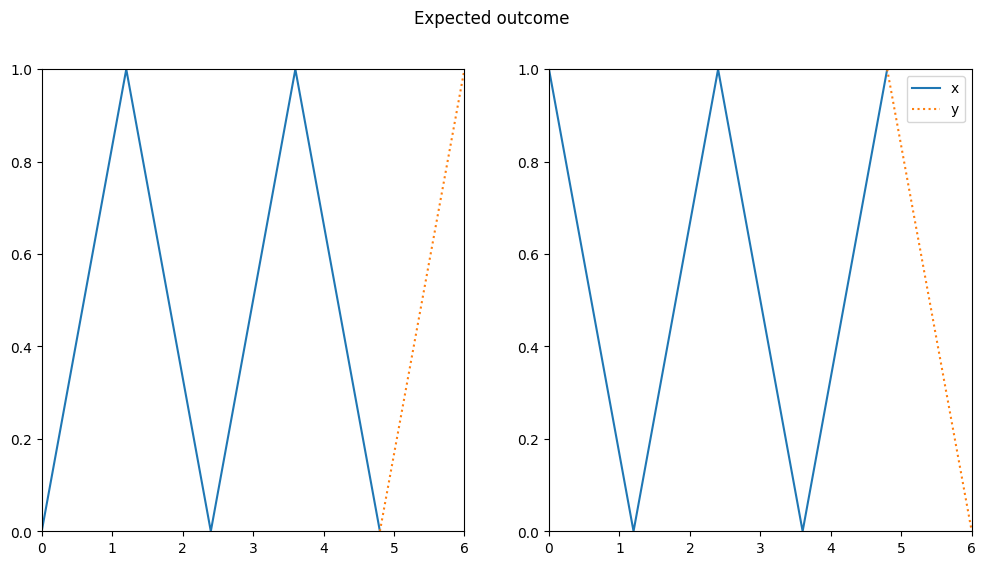

In [7]:
#| echo: false
data_zic_zac = [0, 1, 0, 1, 0] # expected continuation: 1
data_zic_zac2 = [1, 0, 1, 0, 1] # expected continuation: 0
r1 = rnn.forward(data_zic_zac)
r2 = rnn.forward(data_zic_zac2)
plot_zic_zac([data_zic_zac, data_zic_zac2],[1, 0], "Expected outcome")

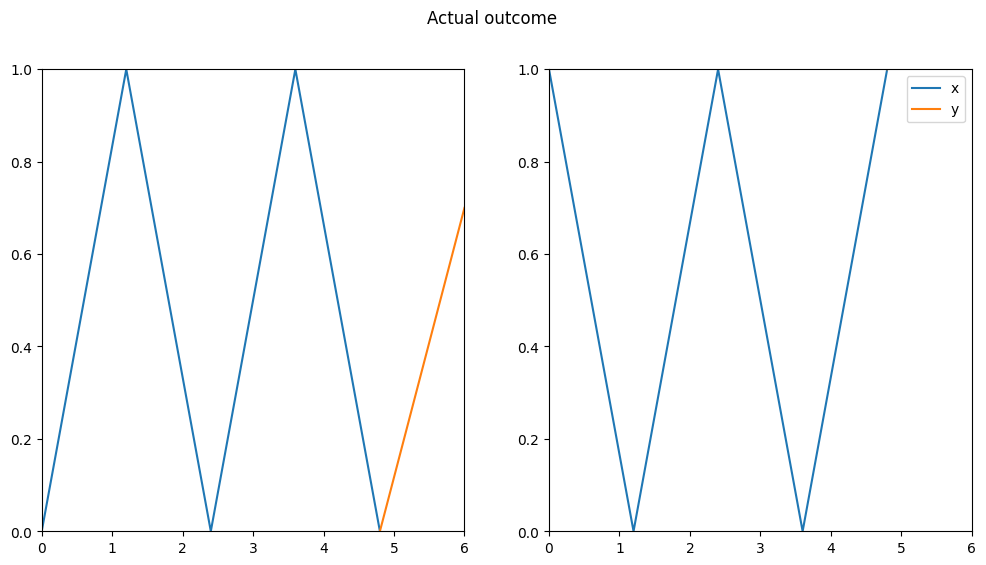

In [8]:
#| echo: false
plot_zic_zac([data_zic_zac, data_zic_zac2],[r1, r2], "Actual outcome", dotted=False)

To make our model perform well on the zigzag dataset, we want to train it using backpropagation. But how does backpropagation work for RNNs? Will it solve our problem with the zigzag shaped data? The goal of this article is to give a concise answer to this question and to provide you with a small model that you can play around by yourself.

In this article we will discuss how to compute the gradients mathematically and afterward, we'll implement these concepts in our model code - without the help of PyTorch.

## Forward

First, we have to think about what the model is doing in a mathematical way, so we'll translate the forward pass into equations. Let's remember how the model was being displayed in the previous part of this series.

![Unrolled schema of an RNN that handles four inputs](images/rnn-unrolled.png){#fig-rnn-unrolled}

The most important thing to note is, that we actually have multiple outputs ($y_0$ to $y_2$ and `output value (y)` in this image). Of course, we are only interested in the last one because this is our prediction, but to define a formula for the RNN we can't forget about the previous ones. The simplest way to do this is to introduce a suffix for the which output we want to reference, called a "timestep".

If you're familiar with programming, you can imagine it like this: The outputs of our RNN are all collected in an array, say `y`. For example: `y = [1, 2, 3, 4]`. To get a specific output, you'd index into the array like so: `y[0]`. In this case, we'd take the model output $y$ at timestep $0$, which we can write as $y_0$ or $y_t$ more generally, $t$ being shorthand for "timestep".

Now, let's write down some formulas to define our model.

::: {.callout-tip}
If you want to get as much value out of this article as possible, I recommend that you try to do it by yourself as a practise before continuing reading the solutions.
:::

### Loss

The loss function, in our case MSE, can be used for a number of variables, but in our case we only have two, the prediction $\hat{y}_t$ and the label $y_t$, so we define it as the following

$$
L = MSE(y_t, \hat{y}_t) =  \frac{1}{2} \cdot (y_t - \hat{y}_t)^2
$$ {#eq-mse}

### Output state

We know that $y_t$ is the label in our training data, but now we have to specify how $\hat{y}_t$ is being calculated from the input data $x$ and the weights $w_{1-3}$. @fig-rnn-weights displays a schematic overview of the weights and states inside our RNN.

![Schema of an RNN with labels for the weights](images/rnn-weights.png){#fig-rnn-weights}

Let's translate this process back-to front into formulas. The last step of calculating $\hat{y}$ is pretty simple, it's just multiplying the hidden state with $w_3$.

$$
\hat{y}_t = h_t \cdot w_3
$$ {#eq-y-hat}

### Hidden state

Our definition of $\hat{y}_t$ includes $h_t$, which we'll try to define now. This is a little bit more complicated, but in essence we're just doing the following steps:

1. Multiply the input $x_t$ with $w_1$
2. Add the result to the previous hidden state $h_{t-1}$
3. Apply the activation function, in our case $\text{ReLU}$

$$
h_t = ReLU(w_1 \cdot x_t + h_{t-1} \cdot w_2)
$$ {#eq-h}

## Backward {#sec-backward}

Given @eq-mse, @eq-y-hat and @eq-h, we now want to find out how to calculate the derivatives for $w_{1-3} $step by step so we can implement the process in our model. I'll try to provide footnotes to the relevant derivative rules where appropriate for readers who are new to the subject.

The gradients we're interested in are those for the variables $w_{1-3}$. Therefore, what we're looking for is the following:

$$
\frac{\partial L}{\partial w_3};
\frac{\partial L}{\partial w_2};
\frac{\partial L}{\partial w_1}
$$

### Loss

To calculate these derivatives, we first need to derive the loss, in our case the MSE in respect to $\hat{y}_t$, because $\hat{y}_t$ is the model prediction and "leads to" all the weights. The derivative^[Power rule] is pretty straight forward, as the exponent and the fraction cancel out nicely.

$$
\frac{{\partial \text{{L}}}}{{\partial \hat{y}_t}}(y_t, \hat{y}_t) = 2 \cdot \frac{1}{2} \left( y_t - \hat{y}_t \right) = y_t - \hat{y}_t \tag{4}
$$

Implementing this in Python gives us the following code.

In [9]:
def mse(x, y):
  return ((x - y)/2)**2

def d_mse(x, y):
  return x - y

### Output state

This alone doesn't suffice, as we have to continue deriving until we find $w_{1-3}$. The third weight can be derived^[Product rule] quickly, following from @eq-y-hat.

$$
\frac{\partial \hat{y}_t}{\partial w_3} = h_t
$$

### Hidden state

The last step is deriving $w_{1-2}$, which are included in @eq-h. Applying the chain-rule, we get the following results ($ReLU'$ means the derivative of the ReLU function).

$$
\frac{\partial h_t}{\partial w_1} = \text{ReLU}'(h_t) \cdot x_t
$$

$$
\frac{\partial h_t}{\partial w_2} = \text{ReLU}'(h_t) \cdot h_{t-1}
$$

### ReLU

$$
\text{{ReLU}}(x) = \begin{cases} x, & \text{if } x > 0 \\ 0, & \text{otherwise} \end{cases}
$$

Considering both cases, we trivially calculate the derivatives^[Line rule, Constant rule] for each of them.

$$
\text{ReLU}'(x) = \begin{cases} 1, & \text{if } x > 0 \\ 0, & \text{otherwise} \end{cases}
$$

In [10]:
def relu(x):
  return max(x,0)

def d_relu(x):
  return x > 0

### Timesteps

At this point, we know how to calculate the gradients when we're at a specific timestep $h_t$. However, we'd like to calculate the gradients in respect to the loss, so based on the chain rule we want to find out:
$$
\frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial w_3}
$$
$$
\frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial h_t} \frac{\partial h_t}{\partial w_2};
$$
$$
\frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial h_t} \frac{\partial h_t}{\partial w_1};
$$

We have already calculated all the derivatives, except $\frac{\partial \hat{y}}{\partial h_t}$. What does this term mean exactly? Let's have a look at the unrolled network once again.

![Schema of an RNN with labels for the weights](images/rnn-weights.png){#fig-rnn-weights}

Considering @eq-y-hat, the deriving^[Product rule] in the case of the last hidden state $h_n$ is straightforward.

$$
\frac{\partial \hat{y}}{\partial h_{n}} = w_2
$$

However, for all previous hidden states $h_t$ the gradient depends on the following state $h_{t+1}$. This is because the gradient "flows" from the loss to the weights. For example, to calculate the gradient for $h_2$ (@fig-rnn-weights), you need to first calculate the gradient for $h_3$ because this is the only "path" that leads to the loss, which is the source of the gradient. So when calculating the gradients, we have to do it step by step, always depending on the later layers $h_{t+1}$. This is also referred to "backpropagation through time".

$$
h_{t+1} = ReLU(h_t \cdot w_2 + x_3 \cdot w_1)
$$

$$
\frac{\partial h_{t+1}}{h_{t}} = ReLU'(h_t) \cdot w_2
$$

And putting it all together, we recursively define the derivative in respect to $h_{t+1}$. This calculation will be done until we arrive at $h_n$, where we can stop.

$$
\frac{\partial \hat{y}}{\partial h_t} = \frac{\partial \hat{y}}{\partial h_{t+1}} \frac{\partial h_{t+1}}{\partial h_{t}}  = \frac{\partial \hat{y}}{\partial h_{t+1}} \cdot ReLU'(h_t) \cdot w_2
$$

### All together

So now we know how to "find a path" from $L$ to any of $w_{1-3}$. However, to calculate the derivative in respect to $w_{1-2}$, we need to consider all the "paths" at once:

![Schema of the RNN depicting the need for multivariable function derivative](images/rnn-comp.png){#fig-rnn-comp}

This is because the weights $w_{1,2}$ are used during all timesteps for the calculation for $\hat{y}$. When calculating the derivatives in respect to the weights, we can't just pick one path and calculate it for this path only, we have to consider all of them at the same time because all of the "paths" influence $L$. Using the derivative rule for variables in a multivariable function, we finally arrive at the following equations.

$$
\frac{\partial L}{\partial w_2} = \frac{\partial L}{\partial \hat{y}} \sum_t{\frac{\partial \hat{y}}{\partial h_t} \frac{\partial h_t}{\partial w_2}} ;
$$

$$
\frac{\partial L}{\partial w_1} = \frac{\partial L}{\partial \hat{y}} \sum_t{\frac{\partial \hat{y}}{\partial h_t} \frac{\partial h_t}{\partial w_1}} ;
$$

## Implementation

To implement all of this in Python, we'll first refactor our `MiniRNN`, introducing the data structures for $h_t$ and $x_t$ which are necessary for calculating the partial derivatives.

In [71]:
#| code-fold: true
#| code-summary: Refactoring MiniRnn

class MiniRnn():
  # Initialize weights
  w1 = torch.rand(1) # linear layer (W_xh)
  w2 = torch.rand(1) # feedback loop (W_hh)
  w3 = torch.rand(1) # output layer (W_hy)
  w1.g, w2.g, w3.g = 0.0, 0.0, 0.0  # <1>

  # Initialize value structures (used for derivatives)
  X = None  # <2>
  h = {0: torch.tensor([0.0])}  # <3>

  def forward(self, X):
    self.X = X

    # Run through the RNN
    for i, x in enumerate(X):
      self.h[i + 1] = relu(self.w1 * x + self.w2 * self.h[i])
      y = self.w3 * self.h[i + 1]

    return y

  # Utility functions for resetting the class
  def clear_states(self):
    self.h = {0:torch.tensor([0.0])}
    self.X = None

  def zero_grads(self):
    self.w1.g, self.w2.g, self.w3.g = 0.0, 0.0, 0.0

1. Initialize the gradients to `0`
2. Data structure for saving the inputs $x_{t}$
3. Data structure for saving the hidden states $h_{t}$

Finally, we'll implement the equations for the partial derivatives from @sec-backward in our model to calculate the gradients in the backwards function^[Partly based on https://victorzhou.com/blog/intro-to-rnns/#7-the-backward-phase]

In [77]:
class MiniRnn():
  # Initialize weights
  w1 = torch.rand(1) # linear layer (W_xh)
  w2 = torch.rand(1) # feedback loop (W_hh)
  w3 = torch.rand(1) # output layer (W_hy)
  w1.g, w2.g, w3.g = 0.0, 0.0, 0.0

  # Initialize value structures (used for derivatives)
  X = None
  h = {0: torch.tensor([0.0])}

  def forward(self, X):
    self.X = X

    # Run through the RNN
    for i, x in enumerate(X):
      self.h[i + 1] = relu(self.w1 * x + self.w2 * self.h[i])
      y = self.w3 * self.h[i + 1]

    return y

  def backward(self, loss_g):
    n = len(self.X)
    self.w3g = self.h[n] * loss_g # <1>
    d_h = self.w3 * loss_g # <2>

    for i in reversed(range(n)):
        tmp = d_h * d_relu(self.h[i+1]) # <3>

        self.w2.g += tmp * self.h[i] # <4>
        self.w1.g += tmp * self.X[i] # <5>

        d_h = tmp * self.w2 # <5>

  def clear_states(self):
    self.h = {0:torch.tensor([0.0])}
    self.X = None

  def zero_grads(self):
    self.w1.g, self.w2.g, self.w3.g = 0.0, 0.0, 0.0

1. Calculate $\frac{\partial L}{\partial w_3}$
2. Calculate $\frac{\partial \hat{y}}{\partial h_{n}}$
3. Introduce temporary variable for less redundant code
4. Calculate $\frac{\partial h_t}{\partial w_2}$
5. Calculate $\frac{\partial h_t}{\partial w_1}$
6. Calculate $\frac{\partial h_{t+1}}{\partial h_{t}}$

### Training

To try out whether our implementation is correct, we can train this model on the previous examples of rising and falling data series.

In [84]:
rnn = MiniRnn()

X = [[0, 0.5], [0.5,0.5],[1,0.5]]
y = [1,0.5,0]

def train(model, epochs=20000, lr=0.001):
  for e in range(epochs):
    for i, x in enumerate(X):
      d_loss = d_mse(model.forward(x), y[i])

      model.backward(d_loss)
      model.w1 -= model.w1.g * lr
      model.w2 -= model.w2.g * lr
      model.w3 -= model.w3.g * lr

      model.zero_grads()

train(rnn)

### Validation

Let's run our model on the examples from the previous article and see how it performs.

In [85]:
#| echo: false
small_rising = [0,0.1]
small_constant = [0.1,0.1]
small_falling = [1,0.9]
small_curve = [0.2,00.1,0.1]

In [86]:
#| echo: false
s1 = rnn.forward(small_rising).item()
s2 = rnn.forward(small_constant).item()
s3 = rnn.forward(small_falling).item()
s4 = rnn.forward(small_curve).item()

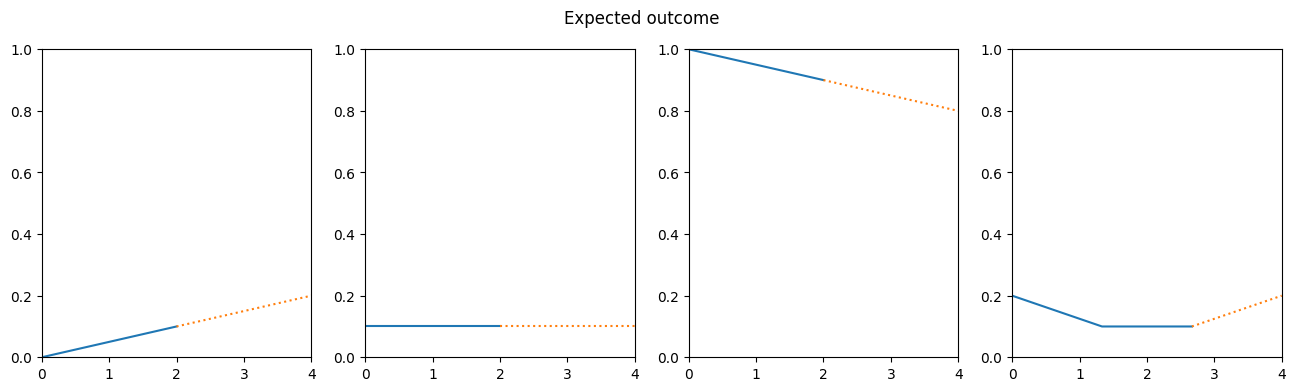

In [87]:
#| label: fig-small-expected
#| fig-cap: "Input validation data arrays with the expected continuation"
#| echo: false
plot_simple([small_rising, small_constant, small_falling, small_curve],[0.2,0.1,0.8,0.2], "Expected outcome")

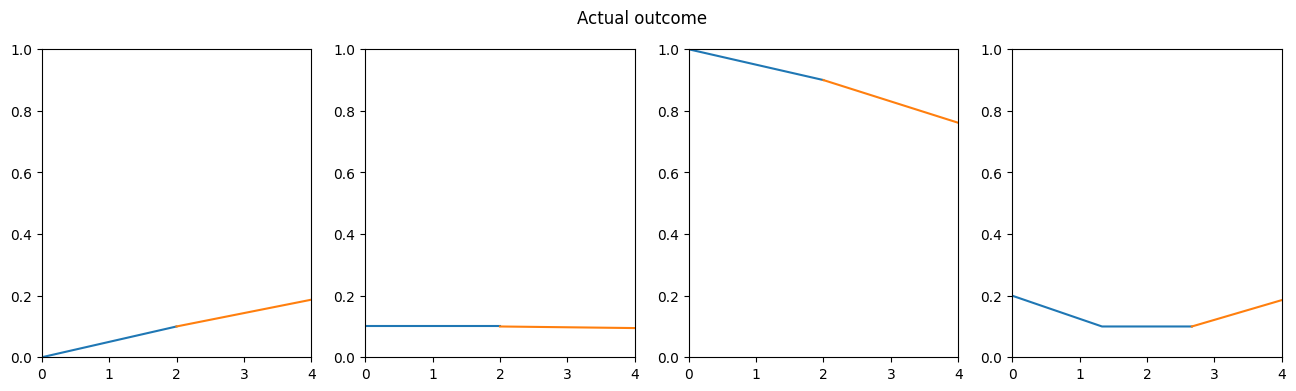

In [88]:
#| label: fig-small-predictions
#| fig-cap: "Input validation data arrays with the model prediction"
#| echo: false
plot_simple([small_rising, small_constant, small_falling, small_curve],[s1,s2,s3,s4], "Actual outcome", dotted=False)

We can also take a look at what the weights look like:

In [89]:
rnn.w1, rnn.w2, rnn.w3

(tensor([2.3161]), tensor([-0.4927]), tensor([0.8070]))

## Zigzag problem

Now let's train our model on the zigzag shapes and see what it predicts on the data.

In [82]:
#| code-fold: true
#| code-summary: Training on zigzag data
rnn = MiniRnn()

X = [data_zic_zac, data_zic_zac2]
y = [1,0]

def train(model, epochs=20000, lr=0.001):
  for e in range(epochs):
    for i, x in enumerate(X):
      d_loss = d_mse(model.forward(x), y[i])

      model.backward(d_loss)
      model.w1 -= model.w1.g * lr
      model.w2 -= model.w2.g * lr
      model.w3 -= model.w3.g * lr

      model.zero_grads()

train(rnn)

In [79]:
#| echo: false
s1 = rnn.forward(data_zic_zac).item()
s2 = rnn.forward(data_zic_zac2).item()

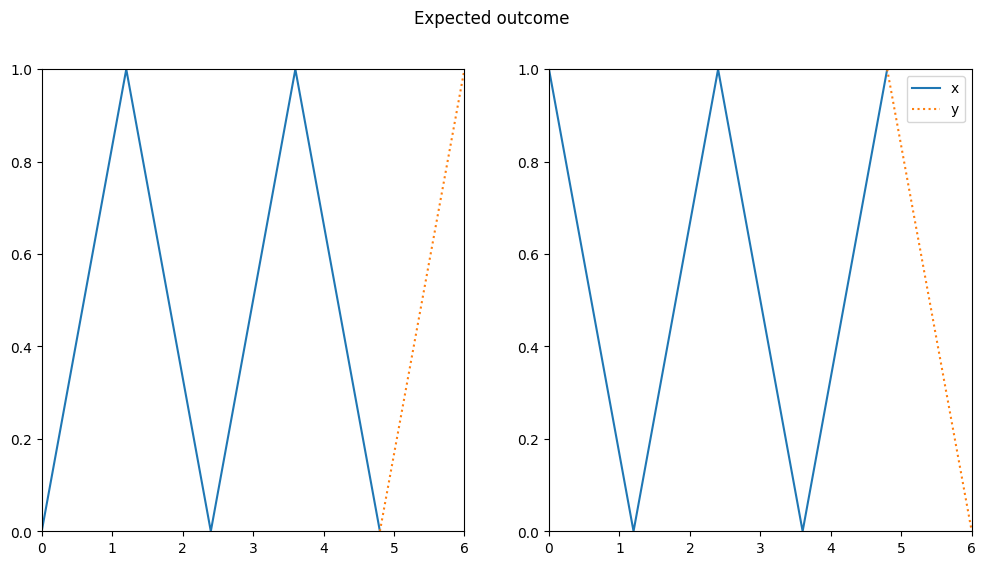

In [80]:
#| echo: false
r1 = rnn.forward(data_zic_zac)
r2 = rnn.forward(data_zic_zac2)
plot_zic_zac([data_zic_zac, data_zic_zac2],[1, 0], "Expected outcome")

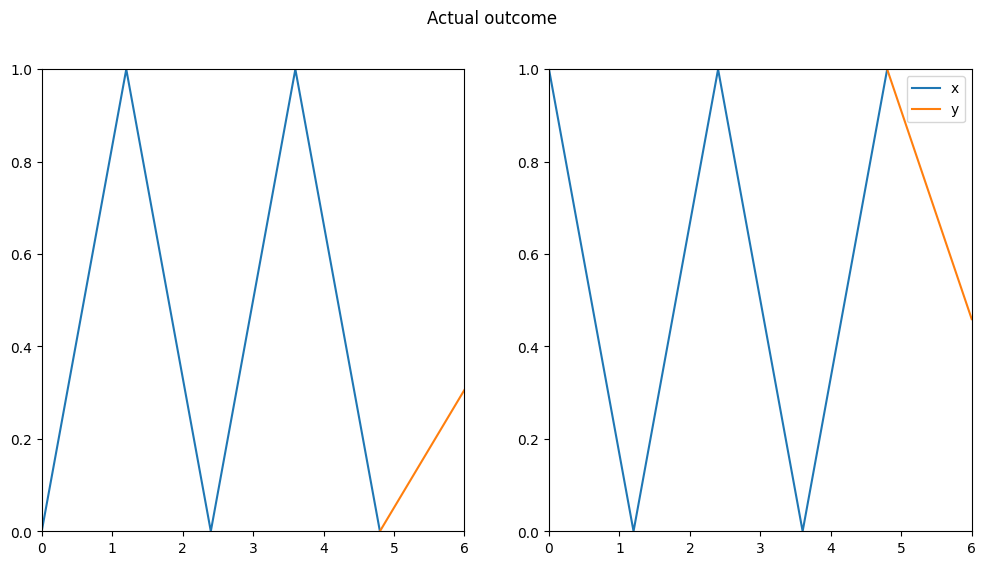

In [81]:
#| label: fig-zigzag-predictions
#| fig-cap: "Zigzag validation data arrays with the model prediction"
#| echo: false
plot_zic_zac([data_zic_zac, data_zic_zac2],[s1, s2], "Actual outcome", dotted=False)

The predictions look better than the one with the previous weights, but they're far from perfect, so we can't really say that the model learned the shape. 

Of course, we could experiment with more shapes and all the hyperparameters, but at this point it's probably best to switch to the successor of the RNN, the LSTM (Long-Term Short-Term Memory) architecture. These kinds of model are in a few ways similar to the RNN, but without some of its drawbacks. They should be able to capture more complicated shapes, and I'd like to introduce them in another article to you.